# WHAT ABOUT THE SUBTRACTING A YEAR FROM ALL THE FEATURES DATES!!!!!!!!  
- probably don't need that red horizontal line in the graphs !!

# Import libraries

In [1]:
# ! pip uninstall -y tensorflow
# ! pip install tensorflow==2.10.*

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import decimal
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import os
from numba import jit
from multiprocessing import Pool
from outer_function_daily import outer_function
from rois import rois_func, portfolio_weights
from functools import partial
import numpy as np
import fredapi as fa
fred = fa.Fred(api_key="5b3325018adf679644bc330c41598801")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam

import bs4 as bs
import requests
import csv
import random
import datetime
import networkx as nx
import time

c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [3]:
# Check if it detects GPU
tf.config.list_physical_devices('GPU') # need to use `! pip install tensorflow==2.10.*` to use gpu on windows 11 natively

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import Data

## Stock price data

In [5]:
# Import data
stocks_df = pd.read_csv("data/price.csv")

# Set date-time index
stocks_df['Date'] = pd.to_datetime(stocks_df["Date"], format='%Y-%m-%d')
stocks_df = stocks_df.set_index(stocks_df['Date'])
stocks_df = stocks_df.drop(columns = ["Date"])

# Drop all columns which only contain nan values
boolean = []
for stock in stocks_df.columns:
    boolean.append(not stocks_df[stock].isnull().all())
stocks_df = stocks_df.iloc[:, boolean]

stocks_df

,AAPL,MSFT,GOOGL,GOOG,AMZN,BRK.B,UNH,JNJ,XOM,V,...,UPST,TAP,WE,CVNA,NVAX,EHAB,OPEN,UWMC,MBC,FG
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,13.291009,NaN,NaN,0.264886,NaN,NaN,NaN,1.888242,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.963844,NaN,NaN,NaN
1990-01-03,NaN,13.488728,NaN,NaN,0.266664,NaN,NaN,NaN,1.895060,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
1990-01-04,NaN,13.510702,NaN,NaN,0.267553,NaN,NaN,NaN,1.891651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
1990-01-05,NaN,13.378882,NaN,NaN,0.268442,NaN,NaN,NaN,1.871201,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
1990-01-08,NaN,13.378882,NaN,NaN,0.270220,NaN,NaN,NaN,1.880794,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,147.929993,44.090000,12.53,139.380005,132.300003,160.580002,167.380005,87.620003,106.489998,62.240002,...,128.589996,33.619999,125.192581,247.149994,32.669998,28.730000,46.130001,68.559998,113.540001,142.470001
2022-12-21,150.089996,44.869999,13.03,142.289993,135.449997,162.210007,169.320007,87.070000,108.139999,63.360001,...,128.779999,33.950001,126.839455,250.839996,33.049999,29.309999,47.570000,69.930000,112.769997,144.919998
2022-12-22,149.009995,43.849998,12.56,142.080002,132.229996,163.270004,169.270004,84.870003,108.029999,62.849998,...,128.820007,33.459999,126.550003,247.509995,32.439999,28.950001,48.279999,65.940002,109.360001,145.029999


In [6]:
# Convert to a numpy array for speedy opterations later on
stocks_np = stocks_df.to_numpy()
stocks_np

array([[         nan,  13.29100895,          nan, ...,          nan,
                 nan,          nan],
       [         nan,  13.48872757,          nan, ...,          nan,
                 nan,          nan],
       [         nan,  13.51070213,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [149.00999451,  43.84999847,  12.56000042, ...,  65.94000244,
        109.36000061, 145.02999878],
       [149.22999573,  44.20000076,  12.71000004, ...,  65.88999939,
        108.77999878, 145.75999451],
       [149.55000305,  44.86000061,  12.52999973, ...,  65.45999908,
        107.56999969, 145.30000305]])

## Categorical variable data

In [7]:
# Read data
cat_variables = pd.read_csv("data/categorical.csv")
cat_variables = cat_variables.set_index("Unnamed: 0")
cat_variables = cat_variables.rename_axis(None, axis = 0)
cat_variables = cat_variables.dropna(axis="columns")

# Drop stocks such that the remaining stocks are those in both cat_variables and stocks_df
intersection = list(set(stocks_df.columns) & set(cat_variables.columns))
cat_variables = cat_variables[intersection]
stocks_df = stocks_df[intersection]

cat_variables

,OZK,NEU,AZO,H,DHR,S,STE,SUI,MRK,CHK,...,SNOW,EPR,LEN.B,SIX,PRU,MET,CDW,TDY,WOLF,TTWO
sectors,Financials,Materials,Consumer Discretionary,Consumer Discretionary,Health Care,Information Technology,Health Care,Real Estate,Health Care,Energy,...,Information Technology,Real Estate,Consumer Discretionary,Consumer Discretionary,Financials,Financials,Information Technology,Information Technology,Information Technology,Communication Services


In [8]:
# Convert to a numpy array for speedy opterations later on
cat_variables_np = cat_variables.to_numpy()
cat_variables_np

array([['Financials', 'Materials', 'Consumer Discretionary', ...,
        'Information Technology', 'Information Technology',
        'Communication Services']], dtype=object)

In [9]:
# Get unique categories for each categorical variable
cats_df = pd.DataFrame()
for cat in cat_variables.index:
    uniques = list(cat_variables.loc[cat, :].unique())
    categories = np.sort(uniques)
    cats_df[cat] = categories

cats_df

,sectors
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Health Care
6,Industrials
7,Information Technology
8,Information technology
9,Materials


## Numerical features data

In [11]:
# Read data
features_daily = pd.read_csv("data/features.csv")
features_daily['Date'] = pd.to_datetime(features_daily["Date"], format='%Y-%m-%d')
features_daily = features_daily.set_index("Date")
features_daily = features_daily.dropna()

# Make names smaller to use in file names
print(features_daily.columns)
features_daily.columns = ['BCI', 'CCI', 'CLI', '3m %', 'Broad $', 'Construction', 'Consumer prices', 'Manu $',
       'Indu production', 'Long %', 'MCI', 'Narrow $', 'Overnight %', 'Cars', 'producer $', 'Retail volume',
       'Total employment', 'Total manu']

features_daily

Index(['BCI', 'CCI', 'CLI', '3 month interbank rate', 'Broad money',
       'Construction', 'Consumer prices', 'Manufacturing hourly earnings',
       'Industrial production', 'Long-term interest rate',
       'Manufacturing confidence indicator', 'Narrow money',
       'Overnight interbank rate', 'Car registrations',
       'Manufacturing producer prices', 'Retail trade volume',
       'Total employment', 'Total manufacturing'],
      dtype='object')


,BCI,CCI,CLI,3m %,Broad $,Construction,Consumer prices,Manu $,Indu production,Long %,MCI,Narrow $,Overnight %,Cars,producer $,Retail volume,Total employment,Total manu
Date,,,,,,,,,,,,,,,,,,
1990-01-01,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-02,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-03,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-04,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-05,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-24,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-25,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796


In [12]:
# Convert to a numpy array for speedy opterations later on
features_daily_np = features_daily.to_numpy()
features_daily_np

array([[9.88230300e+01, 1.00650900e+02, 9.97932100e+01, ...,
        6.75092201e+01, 1.19081000e+05, 6.12449830e+01],
       [9.88230300e+01, 1.00650900e+02, 9.97932100e+01, ...,
        6.75092201e+01, 1.19081000e+05, 6.12449830e+01],
       [9.88230300e+01, 1.00650900e+02, 9.97932100e+01, ...,
        6.75092201e+01, 1.19081000e+05, 6.12449830e+01],
       ...,
       [9.89105400e+01, 9.70624000e+01, 9.88888800e+01, ...,
        1.18300105e+02, 1.59244000e+05, 9.76827961e+01],
       [9.89105400e+01, 9.70624000e+01, 9.88888800e+01, ...,
        1.18300105e+02, 1.59244000e+05, 9.76827961e+01],
       [9.89105400e+01, 9.70624000e+01, 9.88888800e+01, ...,
        1.18300105e+02, 1.59244000e+05, 9.76827961e+01]])

# Hyperparameters

In [13]:
def get_feature_index(feature):
    """
    Returns the index in the numpy feature array using the features name.
    """
    return list(features_daily.columns).index(feature)

def get_cat_index(cat):
    """
    Returns the index in the numpy feature array using the features name.
    """
    return list(cat_variables.index).index(cat)

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [14]:
disable_progress_bars = False

# Constants
MAX_EPOCHS = 200
PATIENCE = 15
NUMBER_OF_RATES = 3

## Hyperparameters to try
# Neural network hyperparameters to try
layers = [2, 3, 4]
neurons = [32, 64, 128]
# Techniques to try
techniques = ["base", "dropout layers", "batch regularisation", "dropout & batch"]
# Other hyperparameters
years = [3, 4, 5]
lines = [16, 32,64]
batch_sizes = [2048]

# The categorical and numeric features included in the data are the ones at the SAME INDEX !!! ######################## what does this mean????????????????
cats_subsets = [["sectors"]]
features_subsets = [["Manu $", "Narrow $", "Cars", "Indu production"]]


if len(cats_subsets) != len(features_subsets):
    raise ValueError("The length of `cats_subsets` & `features_subsets` must be the same since the features included in the model "
                     "are those at the same indexes of these lists.")
all_cats = set()
for subset in cats_subsets:
    for var in subset:
        all_cats.add(var)
all_features = set()
for subset in features_subsets:
    for var in subset:
        all_features.add(var)

# Sort for consistency
all_cats = sorted(list(all_cats))
all_features = sorted(list(all_features))

all_cats_indexes = []
for var in all_cats:
    all_cats_indexes.append(get_cat_index(var))
all_features_indexes = []
for var in all_features:
    all_features_indexes.append(get_feature_index(var))


##### FOR `cats_subsets`
# Sort the names so that the name of the model files and graphs will always be the same regardless of the order of the names in the subset
# which allows the program to skip creating the model as it has already been created.
for i in range(len(cats_subsets)):
    cats_subsets[i].sort()

cats_indexes = []
for subset_names in cats_subsets:
    subset_indexes = []
    for feature in subset_names:
        subset_indexes.append(get_cat_index(feature))
    cats_indexes.append(subset_indexes)


##### FOR `features_subsets`
# Sort the names so that the name of the model files and graphs will always be the same regardless of the order of the names in the subset
# which allows the program to skip creating the model as it has already been created.
for i in range(len(features_subsets)):
    features_subsets[i].sort()

features_subsets_indexes = []
for subset_names in features_subsets:
    subset_indexes = []
    for feature in subset_names:
        subset_indexes.append(get_feature_index(feature))
    features_subsets_indexes.append(subset_indexes)

# Local host stuff

If cannot connect to local hosot, run both of the following commands in cmd using the code block below:
* `taskkill /im tensorboard.exe /f`
* `del /q %TMP%\.tensorboard-info\*`

In [15]:
# import os
# os.system('cmd /k "taskkill /im tensorboard.exe /f"')
# os.system('cmd /k "del /q %TMP%\.tensorboard-info\*"')
# 
# %load_ext tensorboard
# %tensorboard --logdir results --host localhost

# Training neural network on created data

* Very good explanation of [multiprocessing mapping methods](https://stackoverflow.com/questions/26520781/multiprocessing-pool-whats-the-difference-between-map-async-and-imap).
* Good explanation of affect of [optimal chunksize](https://stackoverflow.com/questions/34988692/python-3-multiprocessing-optimal-chunk-size)

**I THINK THERE MAY STILL BE ROOM FOR IMPROVEMENT FOR IN MULTIPROCESSING BY VARYING CHUNKSIZE IN `imap` METHOD.**

In [16]:
def graph_already_completed(graph_path, layer, neuron):
    completed_graphs = os.listdir(graph_path)
    for graph_name in completed_graphs:
        if f"{layer}L-{neuron}N" in graph_name:
            return True
    return False

In [17]:
root_folder = "results (daily)"
overview_folder = "overview"
details_folder = "details"

# Create/load file to store results of each model
try:
    os.makedirs(f"{root_folder}/{overview_folder}")
except FileExistsError:
    pass


model_results_path = f"{root_folder}/{overview_folder}/model results.csv"
try:
    results = pd.read_csv(model_results_path)
except FileNotFoundError:
    # If the file does not exist then we create the file
    with open(model_results_path, "w") as f:
        f.write(",".join(["features","lines", "years", "layers", "neurons per layer", "total neurons", "batch size", "technique", "val_r_square"]) + "\n")
    results = pd.read_csv(model_results_path)

results

,features,lines,years,layers,neurons per layer,total neurons,batch size,technique,val_r_square
0,[sectors Cars Indu production Manu $ Narrow $],16,3,2,32,64,2048,base,0.888129
1,[sectors Cars Indu production Manu $ Narrow $],16,3,2,32,64,2048,dropout layers,0.877544
2,[sectors Cars Indu production Manu $ Narrow $],16,3,2,32,64,2048,batch regularisation,0.859031
3,[sectors Cars Indu production Manu $ Narrow $],16,3,2,32,64,2048,dropout & batch,0.825218
4,[sectors Cars Indu production Manu $ Narrow $],16,3,2,64,128,2048,base,0.888584


In [18]:
# This also ensures that all the hyperparameters sets where no features (other than stock price) are considered always run first as they
# act as a base to compare to.
base_hyperparameter_combinations = []
for NUMBER_OF_LINES in lines:
    for NUMBER_OF_YEARS_TO_CONSIDER in years:
        tup = (NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER)
        base_hyperparameter_combinations.append(tup)

base_hyperparameter_combinations

[(16, 3),
 (16, 4),
 (16, 5),
 (32, 3),
 (32, 4),
 (32, 5),
 (64, 3),
 (64, 4),
 (64, 5)]

In [19]:
# This also ensures that all the hyperparameters sets where no features (other than stock price) are considered always run first as they
# act as a base to compare to.
feature_combinations = []
for (subset_i, features_subset), (subset_j, cats_index) in zip(enumerate(features_subsets_indexes), enumerate(cats_indexes)):
    tup = ((subset_i, features_subset), (subset_j, cats_index))
    feature_combinations.append(tup)

feature_combinations

[((0, [13, 8, 7, 11]), (0, [0]))]

## Training the models

In [23]:
def plot(history, model, x_test, y_train, y_test, features_string, batch_size, i, R2, test_predictions):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

    # PLot actual vs prediction scatter plot
    test_predictions = test_predictions.flatten()
    ax[0].scatter(y_test, test_predictions, alpha=0.01)
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')

    # Plot y=x line
    # ax[0].axline((0, 0), slope=1, c='green', linewidth=2)
    points = [0, max(max(y_test), max(test_predictions))]
    ax[0].plot(points, points, color="green", linewidth = 3)
    ax[0].set_title("True values against predictions")
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    # Plot training and testing r-squared
    ax[1].plot(history.history['r_square'], label='r_square')
    ax[1].plot(history.history['val_r_square'], label='val_r_square')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Error')
    ax[1].set_title('R-Squared')
    ax[1].set_ylim([0, 1])
    ax[1].set_yticks(np.arange(0, 1.05, 0.05))
    # xticks = np.arange(len(history.history['val_r_square'])) + 1
    # ax[1].set_xticks(xticks.astype(int))

    fig.suptitle(f"Test R2={round(R2,3)}, BS={batch_size}, result index={i}, {features_string}", fontsize="small")

    plt.legend()
    plt.grid(True)
    return fig

In [24]:
def models_remaining(layers, neurons, batch_sizes, techniques,feature_combinations, models_to_redo_by_index):
    for layer in layers:
        for neuron in neurons:
            for BATCH_SIZE in batch_sizes:
                for technique in techniques:
                    for (subset_i, features_subset), (subset_j, cats_index) in feature_combinations:
                        features_string = f"{cats_subsets[subset_j] + features_subsets[subset_i]}".replace("'","").replace(",","")
                        row = [features_string, NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER, layer, neuron, layer*neuron, BATCH_SIZE, technique]

                        # The following determines if the current `row` index was designated to be trained further. The try-except clause takes into account the case
                        # where the `row` doesn't exist in `results` df.
                        try:
                            idx = (results[results.columns[:-1]] == row).index[0]
                        except IndexError:
                            boolean = False
                        else:
                            boolean = idx in models_to_redo_by_index
                        # If the model has been trained or needs to be trained more, we return True
                        if not (results[results.columns[:-1]] == row).all(1).any() or boolean:
                            return True
    return False

In [25]:
models_to_redo_by_index = []

Completed models:   0%|          | 0/324 [00:00<?, ?it/s]

Working on Dataset: 16 lines, 3 years:   0%|          | 0/6851 [00:00<?, ?it/s]

[[-1.20077523e-02  1.18083463e-02 -2.80185549e-02 ... -3.27100657e-02
   1.42519188e+01  2.20107765e+01]
 [ 7.24663501e-04  4.10631739e-04 -1.71848093e-03 ... -5.87561614e-04
   2.30860427e-01  2.63182461e-01]
 [-9.32663268e-04  8.98324470e-03 -3.55583253e-04 ... -2.82317040e-03
   3.46025252e+00  5.00519133e+00]
 ...
 [ 2.05124583e-01 -1.67932039e-01  1.67128271e-02 ... -3.76569270e-01
   1.06279999e+02  3.21199989e+01]
 [-2.51722271e-02  4.13431579e-03  7.15533175e-02 ... -6.15805373e-02
   5.16699982e+01  4.84500008e+01]
 [ 1.72831766e-01  1.86029361e-02  1.64174320e-01 ...  4.88611922e-01
   1.99428116e+02  1.45759995e+02]]

ALREADY COMPLETED model:
Data: 16Lines-3Years-[Cars, Indu production, Manu $, Narrow $]Features-[sectors]Categorical
Layers: 2
Neurons: 32
Batch size = 2048
Technique = base


ALREADY COMPLETED model:
Data: 16Lines-3Years-[Cars, Indu production, Manu $, Narrow $]Features-[sectors]Categorical
Layers: 2
Neurons: 32
Batch size = 2048
Technique = dropout layers


A

Trying different rates:   0%|          | 0/3 [00:00<?, ?it/s]

Getting rois for rate: 0.333:   0%|          | 0/3 [00:00<?, ?it/s]

Getting rois for rate: 0.667:   0%|          | 0/3 [00:00<?, ?it/s]

Getting rois for rate: 1.0:   0%|          | 0/3 [00:00<?, ?it/s]

2044/2044 [==============================] - 2s 956us/step


Getting portfolio rois:   0%|          | 0/6851 [00:00<?, ?it/s]

Creating interactive scatterplot
Saving interactive scatterplot
Saved interactive scatterplot

Working on model:
Data: 16Lines-3Years-[Cars, Indu production, Manu $, Narrow $]Features-[sectors]Categorical
Layers: 2
Neurons: 64
Batch size = 2048
Technique = batch regularisation

Epoch 1/200
1398/1398 [==============================] - 9s 5ms/step - loss: 65.5015 - r_square: -0.1533 - val_loss: 42.2822 - val_r_square: -0.1670
Epoch 2/200
1398/1398 [==============================] - 7s 5ms/step - loss: 64.5889 - r_square: -0.1526 - val_loss: 41.8977 - val_r_square: -0.1626
Epoch 3/200
1398/1398 [==============================] - 7s 5ms/step - loss: 63.9743 - r_square: -0.1483 - val_loss: 41.4563 - val_r_square: -0.1568
Epoch 4/200
1398/1398 [==============================] - 7s 5ms/step - loss: 63.3555 - r_square: -0.1444 - val_loss: 40.8639 - val_r_square: -0.1531
Epoch 5/200
1398/1398 [==============================] - 7s 5ms/step - loss: 62.7229 - r_square: -0.1416 - val_loss: 40.3292 

Trying different rates:   0%|          | 0/3 [00:00<?, ?it/s]

Getting rois for rate: 0.333:   0%|          | 0/3 [00:00<?, ?it/s]

Getting rois for rate: 0.667:   0%|          | 0/3 [00:00<?, ?it/s]

Getting rois for rate: 1.0:   0%|          | 0/3 [00:00<?, ?it/s]

2044/2044 [==============================] - 3s 1ms/step


Getting portfolio rois:   0%|          | 0/6851 [00:00<?, ?it/s]

Creating interactive scatterplot
Saving interactive scatterplot
Saved interactive scatterplot

Working on model:
Data: 16Lines-3Years-[Cars, Indu production, Manu $, Narrow $]Features-[sectors]Categorical
Layers: 2
Neurons: 64
Batch size = 2048
Technique = dropout & batch

Epoch 1/200
1398/1398 [==============================] - 10s 6ms/step - loss: 66.8226 - r_square: -0.1598 - val_loss: 43.2946 - val_r_square: -0.1760
Epoch 2/200
1398/1398 [==============================] - 9s 6ms/step - loss: 66.2749 - r_square: -0.1554 - val_loss: 43.0196 - val_r_square: -0.1769
Epoch 3/200
1398/1398 [==============================] - 10s 7ms/step - loss: 65.7333 - r_square: -0.1508 - val_loss: 42.7150 - val_r_square: -0.1754
Epoch 4/200
1398/1398 [==============================] - 9s 6ms/step - loss: 65.1939 - r_square: -0.1469 - val_loss: 42.4052 - val_r_square: -0.1725
Epoch 5/200
1398/1398 [==============================] - 9s 6ms/step - loss: 64.6631 - r_square: -0.1430 - val_loss: 42.0886 - v

KeyboardInterrupt: 

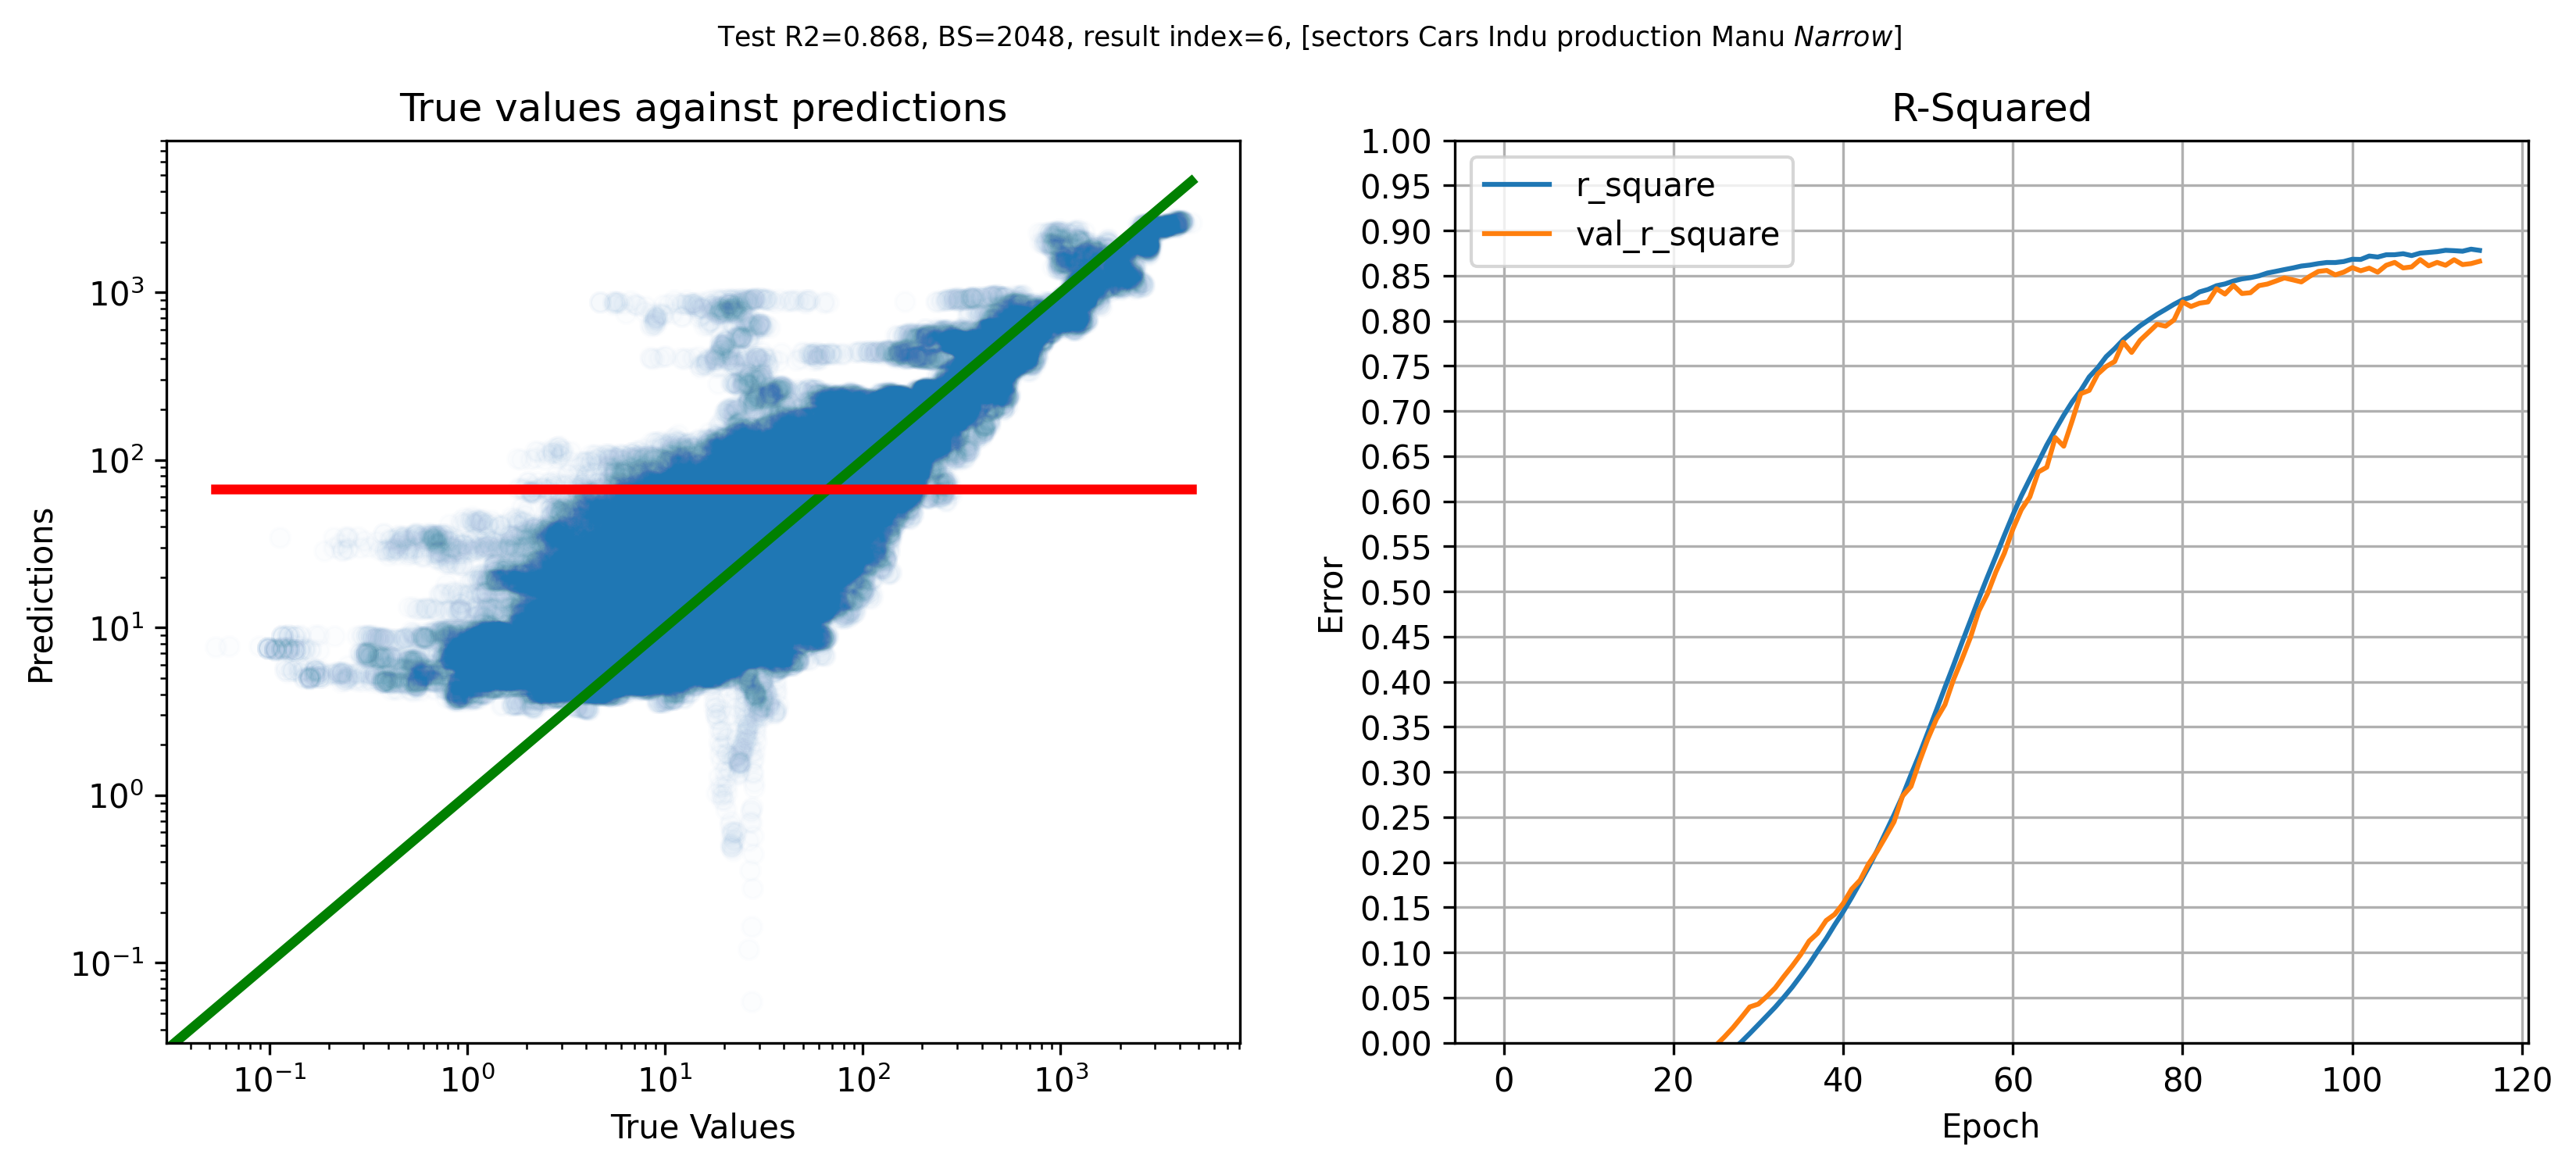

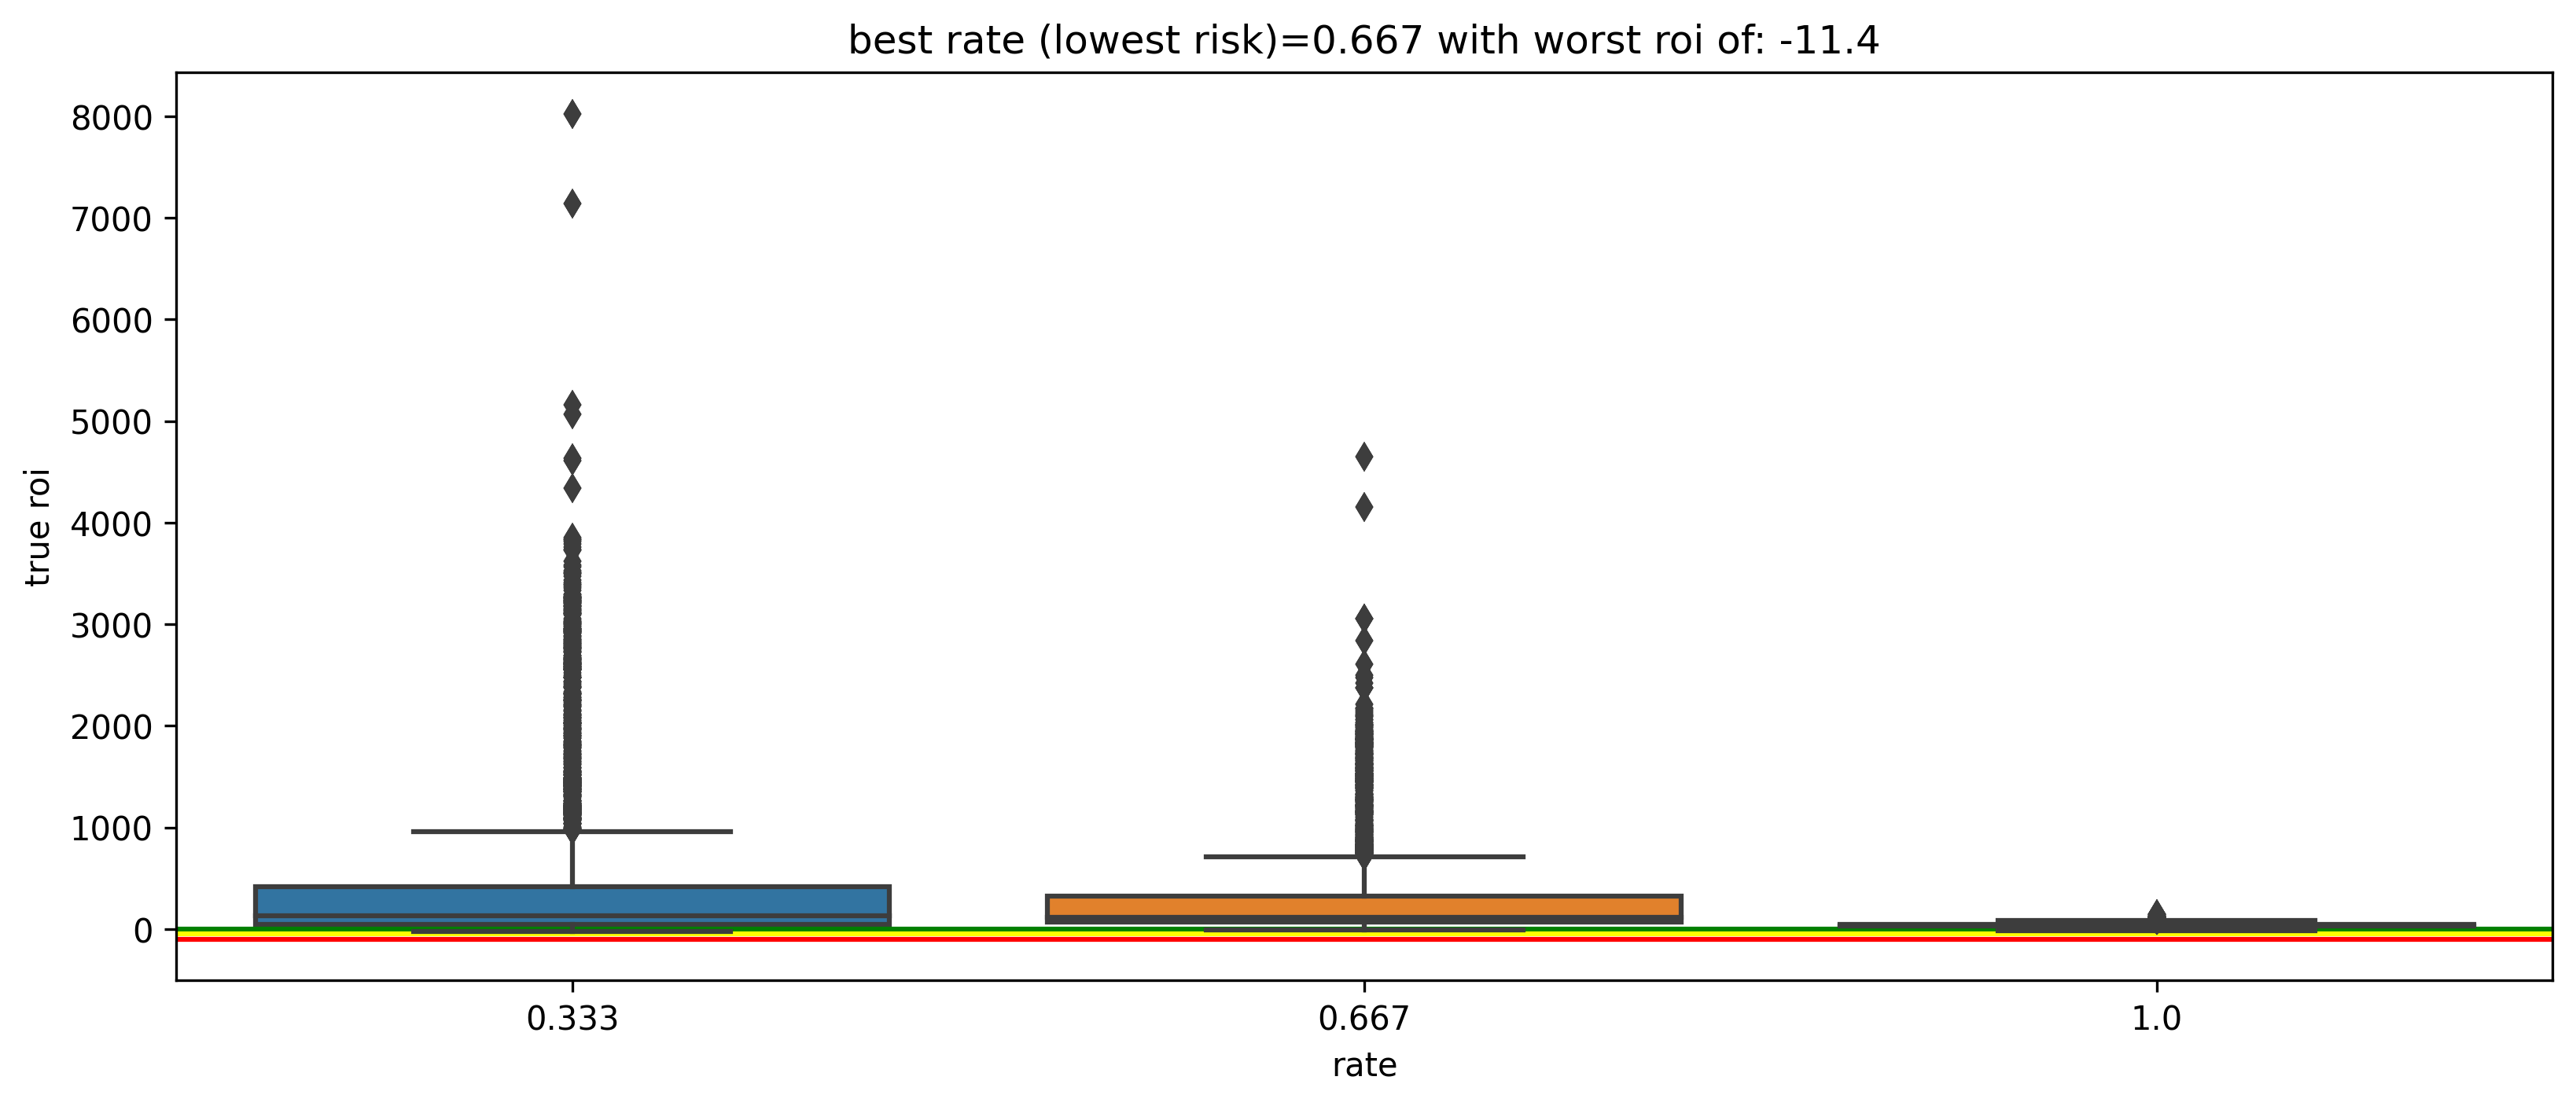

In [27]:
p = Pool(os.cpu_count())
pbar = tqdm(total=len(base_hyperparameter_combinations)*len(feature_combinations)*len(layers)*len(neurons)*len(batch_sizes)*len(techniques), desc = "Completed models")
for NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER in base_hyperparameter_combinations:
    if models_remaining(layers, neurons, batch_sizes, techniques,feature_combinations, models_to_redo_by_index):
        if NUMBER_OF_LINES <= NUMBER_OF_YEARS_TO_CONSIDER*365:
            first_index = NUMBER_OF_YEARS_TO_CONSIDER*365+1 # `+1` needed since slicing is end-exclusive
            range_iterations = range(first_index, len(stocks_np) - 365)

            iterations = tqdm(range_iterations,
                              desc=f"Working on Dataset: {NUMBER_OF_LINES} lines, {NUMBER_OF_YEARS_TO_CONSIDER} years",
                              disable=False)

            result_list = p.map(partial(outer_function,
                                        stocks_np = stocks_np,
                                        NUMBER_OF_YEARS_TO_CONSIDER = NUMBER_OF_YEARS_TO_CONSIDER,
                                        NUMBER_OF_LINES = NUMBER_OF_LINES,
                                        features_subset_indexes = all_features_indexes,
                                        features_np = features_daily_np,
                                        cats_np = cat_variables_np,
                                        cats_index = all_cats_indexes,
                                        cats_df = cats_df,
                                        dates = np.array(stocks_df.index),
                                        stocks = np.array(stocks_df.columns)
                                        ),
                                iterations)

            data = np.vstack([result[0] for result in result_list])
            data_dates = np.hstack([result[1] for result in result_list])
            data_stocks = np.hstack([result[2] for result in result_list])

            cats_dict = dict()
            for k in all_cats_indexes:
                cats_dict[k] = np.hstack([result_list[i][3][k] for i in range(len(result_list))])

            features_dict = dict()
            for k in all_features_indexes:
                features_dict[k] = np.vstack([result_list[i][4][k] for i in range(len(result_list))])


            # Creating neural networks
            for layer in layers:
                for neuron in neurons:
                    for BATCH_SIZE in batch_sizes:
                        for technique in techniques:
                            for (subset_i, features_subset), (subset_j, cats_index) in feature_combinations:
                                data_name = f"{NUMBER_OF_LINES}Lines-{NUMBER_OF_YEARS_TO_CONSIDER}Years-{features_subsets[subset_i]}Features-{cats_subsets[subset_j]}Categorical".replace("'", "")
                                features_string = f"{cats_subsets[subset_j] + features_subsets[subset_i]}".replace("'","").replace(",","")
                                row = [features_string, NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER, layer, neuron, layer*neuron, BATCH_SIZE, technique]
                                # The following determines if the current `row` index was designated to be trained further. The try-except clause takes into account the case
                                # where the `row` doesn't exist in `results` df.
                                try:
                                    idx = (results[results.columns[:-1]] == row).index[0]
                                except IndexError:
                                    boolean = False
                                else:
                                    boolean = idx in models_to_redo_by_index
                                    # If the model has been trained or needs to be trained more, we return True
                                if not (results[results.columns[:-1]] == row).all(1).any() or boolean:

                                    categorical_dummy_dfs_list = []
                                    for c in cats_index:
                                        categorical_dummy_dfs_list.append(pd.get_dummies(cats_dict[c]).iloc[:,:-1])


                                    # The `data` list must go last since the rest of the script expects the dependent variable to be the last column !!
                                    model_data = np.hstack(categorical_dummy_dfs_list + [features_dict[f] for f in features_subset] + [data])


                                    # Create data for model
                                    tuples = list(zip(data_dates, data_stocks))
                                    index = pd.MultiIndex.from_tuples(tuples, names=["dates", "stocks"])
                                    model_data = pd.DataFrame(model_data, index=index)

                                    model_data_train = pd.concat([model_data.loc[:"2006-5-1",:], model_data.loc["2014-5-1":,:]], axis="rows").sample(frac=1,
                                                                                                                                                     random_state=1)
                                    model_data_test = model_data.loc["2006-5-1":"2014-5-1", :]

                                    x_train = model_data_train.iloc[:,:-1]
                                    y_train = model_data_train.iloc[:,-1]

                                    x_test = model_data_test.iloc[:,:-1]
                                    y_test = model_data_test.iloc[:,-1]

                                    test_dates = model_data_test.index
                                    
                                    # Create folders
                                    graphs_path = f'{root_folder}/{details_folder}/{technique}/models training & testing/{data_name}'
                                    try:
                                        os.makedirs(graphs_path)
                                    except FileExistsError:
                                        pass

                                    models_path = f'{root_folder}/{details_folder}/{technique}/models/{data_name}'
                                    try:
                                        os.makedirs(models_path)
                                    except FileExistsError:
                                        pass

                                    portfolio_creation_testing_path = f"{root_folder}/{details_folder}/{technique}/investment results/testing/{data_name}"
                                    try:
                                        os.makedirs(portfolio_creation_testing_path)
                                    except FileExistsError:
                                        pass

                                    portfolio_creation_training_path = f"{root_folder}/{details_folder}/{technique}/investment results/training/{data_name}"
                                    try:
                                        os.makedirs(portfolio_creation_training_path)
                                    except FileExistsError:
                                        pass

                                    model_name = f"{BATCH_SIZE}BS-{layer}Layers-{neuron}Neurons"

                                    print(f"\n"
                                          f"Working on model:\n"
                                          f"Data: {data_name}\n"
                                          f"Layers: {layer}\n"
                                          f"Neurons: {neuron}\n"
                                          f"Batch size = {BATCH_SIZE}\n"
                                          f"Technique = {technique}\n")

                                    # Normalize the data
                                    normalizer = preprocessing.Normalization(axis=-1)

                                    # The following determines if the current `row` index was designated to be trained further. The try-except clause takes into account the case
                                    # where the `row` doesn't exist in `results` df.
                                    try:
                                        idx = (results[results.columns[:-1]] == row).index[0]
                                    except IndexError:
                                        boolean = False
                                    else:
                                        boolean = idx in models_to_redo_by_index
                                        # If the model has been trained or needs to be trained more, we return True
                                    if not boolean:
                                        model = Sequential()
                                        model.add(normalizer)
                                        if technique == "dropout & batch":
                                            for _ in range(layer):
                                                model.add(Dense(neuron))
                                                model.add(BatchNormalization(axis=1))
                                                model.add(Activation("relu"))
                                                model.add(Dropout(0.5))
                                        else:
                                            for _ in range(layer):
                                                model.add(Dense(neuron))
                                                if technique == "batch regularisation":
                                                    model.add(BatchNormalization(axis=1))

                                                model.add(Activation("relu"))

                                                if technique == "dropout layers":
                                                    model.add(Dropout(0.5))
                                        model.add(Dense(1))
                                    else:
                                        model = tf.keras.models.load_model(f"{models_path}/{model_name}.h5")

                                    model.compile(loss='mean_absolute_error',
                                                  optimizer= Adam(learning_rate=0.00001),
                                                  metrics=[RSquare()])

                                    checkpoint_cb = ModelCheckpoint(f"{models_path}/{model_name}.h5",
                                                                    monitor='val_r_square',
                                                                    save_best_only=True,
                                                                    verbose=0,
                                                                    save_weights_only=False,
                                                                    mode = "max")
                                    early_stopping_cb = EarlyStopping(monitor = "val_r_square",
                                                                      patience = PATIENCE, # No. epochs with no improvement after which training is stopped.
                                                                      restore_best_weights=True,
                                                                      verbose = 0,
                                                                      min_delta = 0.01, # Increase of 0.01 per `PATIENCE` iterations required at least
                                                                      mode = "max")

                                    
                                    # tensorboard_callback = tf.keras.callbacks.TensorBoard(f"{root_folder}/{details_folder}/{technique}/logs/{data_name}/{model_name}")

                                    # reducelr_cb = ReduceLROnPlateau(monitor='val_r_square',
                                    #                                 factor=0.5,
                                    #                                 patience=REDUCE_LR_PATIENCE,
                                    #                                 verbose = 0,
                                    #                                 mode = "max")

                                    history = model.fit(
                                        x_train, y_train,
                                        validation_data = (x_test, y_test),
                                        verbose=1,
                                        epochs=MAX_EPOCHS,
                                        callbacks=[checkpoint_cb, early_stopping_cb], # , tensorboard_callback , reducelr_cb
                                        batch_size = BATCH_SIZE)

                                    model = tf.keras.models.load_model(f"{models_path}/{model_name}.h5")

                                    # Calculate r-squared
                                    test_predictions = model.predict(x_test, batch_size=BATCH_SIZE)
                                    R2_score = r2_score(y_test, test_predictions)
                                    plt.close("all")
                                    index = len(results)
                                    fig = plot(history, model, x_test, y_train, y_test, features_string, BATCH_SIZE, index, R2_score, test_predictions)
                                    plt.savefig(
                                        f'{graphs_path}/{model_name}.png',
                                        bbox_inches='tight',
                                        dpi = 300
                                    )

                                    # plt.show(fig)

                                    # Portfolio creation
                                    x_train_dates = [i[0] for i in x_train.index]
                                    x_train_stock = [i[1] for i in x_train.index]
                                    train_predictions = model.predict(x_train, batch_size=BATCH_SIZE)
                                    portfolio_data = np.array([x_train_dates,
                                                               x_train_stock,
                                                               x_train.iloc[:,-1],
                                                               y_train.values,
                                                               train_predictions[:,0]]
                                                              )
                                    portfolio_data = pd.DataFrame(portfolio_data.T,
                                                                  columns = ["date", "stock", "current price", "true 1 year", "predicted 1 year"])

                                    portfolio_data = portfolio_data.set_index("date")
                                    portfolio_data = portfolio_data.sort_values(by=["date", "predicted 1 year"], ascending=[True, False])

                                    rois_data = []
                                    pbar2 = tqdm(np.linspace(0,1,NUMBER_OF_RATES+1)[1:], desc="Trying different rates", total=NUMBER_OF_RATES)
                                    for rate in pbar2:
                                        rate = np.round(rate,3)
                                        tups = []
                                        for i in range(NUMBER_OF_RATES):
                                            tups.append((rate, portfolio_data))
                                        tups_tqdm = tqdm(tups, desc=f"Getting rois for rate: {rate}", total=len(tups))
                                        rois = p.map(rois_func, tups_tqdm)
                                        rois_data.append(np.vstack(rois))
                                    pbar2.close()

                                    rois_data = np.vstack(rois_data)
                                    rois_data = pd.DataFrame(rois_data, columns=["rate", "true roi", "expected roi", "num unique stocks"])
                                    # Drop nan rows as those represent times when all stocks were expected to go down
                                    rois_data = rois_data.dropna()

                                    best_rate = rois_data[["true roi", "rate"]].groupby(["rate"]).min().idxmax(axis="rows")[0]
                                    best_rate_min_roi = rois_data[["true roi", "rate"]].groupby(["rate"]).min().max(axis="rows")[0]

                                    plt.figure(figsize=(13, 5), dpi=300)

                                    # We are only going to invest when we expect a positive roi so only consider those.
                                    positive_rois_data = rois_data.loc[rois_data["expected roi"]>0,:]
                                    plt.axhline(0, color="green")
                                    plt.axhline(-50, color="yellow")
                                    plt.axhline(-100, color="red")
                                    sns.boxplot(data=positive_rois_data, x="rate", y="true roi") # , showfliers = False
                                    plt.title(f"best rate (lowest risk)={best_rate} with worst roi of: {round(best_rate_min_roi,2)}")
                                    plt.savefig(f"{portfolio_creation_training_path}/{model_name}.jpg")


                                    # Portfolio creation - interactive plot for testing data
                                    features_dates = [i[0] for i in model_data.iloc[:,:-1].index]
                                    features_stock = [i[1] for i in model_data.iloc[:,:-1].index]
                                    features_predictions = model.predict(model_data.iloc[:,:-1], batch_size=BATCH_SIZE)
                                    portfolio_data = np.array([features_dates,
                                                               features_stock,
                                                               model_data.iloc[:,:-1].iloc[:,-1],
                                                               model_data.iloc[:,-1].values,
                                                               features_predictions[:,0]]
                                                              )
                                    portfolio_data = pd.DataFrame(portfolio_data.T,
                                                                  columns = ["date", "stock", "current price", "true 1 year", "predicted 1 year"])

                                    portfolio_data = portfolio_data.sort_values(by=["date", "predicted 1 year"], ascending=[True, False])
                                    portfolio_data = portfolio_data.set_index("date")
                                    port_index = portfolio_data.index.unique()

                                    port_index_tqdm = tqdm(enumerate(port_index), desc="Getting portfolio rois", total=len(port_index))
                                    rois = np.zeros((len(port_index),2))
                                    extra_data = []
                                    for i, date in port_index_tqdm:
                                        if date in test_dates:
                                            dataset_string = "test"
                                        else:
                                            dataset_string = "train"

                                        # filter out relevant rows
                                        current_df = portfolio_data.loc[date,:]

                                        # Get array containing expected roi for each stock
                                        expected_roi_per_stock = ((current_df["predicted 1 year"].values - current_df["current price"].values)/current_df["current price"].values)*100
                                        current_df["expected roi"] = expected_roi_per_stock

                                        current_df = current_df.sort_values(["expected roi"], ascending=False)
                                        current_prices = current_df["current price"]
                                        current_stocks = current_df["stock"]
                                        expected_roi_per_stock = current_df["expected roi"]

                                        weights, num_stocks = portfolio_weights(best_rate, expected_roi_per_stock)

                                        stocks_to_show = 10
                                        weights_string = " ".join(list([str(round(num, 2)) for num in list(weights)[:stocks_to_show]]))
                                        stocks_string = " ".join(list(current_stocks)[:stocks_to_show])
                                        current_prices_string = " ".join(list([str(round(num, 2)) for num in list(current_prices)[:stocks_to_show]]))
                                        predicted_prices_string = " ".join(list([str(round(num, 2)) for num in list(current_df["predicted 1 year"])])[:stocks_to_show])
                                        expected_roi_string = " ".join(list([str(round(num, 2)) for num in list(expected_roi_per_stock)[:stocks_to_show]]))
                                        true_price_string = " ".join(list([str(round(num, 2)) for num in list(current_df["true 1 year"])[:stocks_to_show]]))

                                        current_portfolio_wealth = sum([weights[w] * decimal.Decimal(current_df["current price"][w]) for w in range(len(weights))])
                                        current_portfolio_wealth = float(current_portfolio_wealth)


                                        future_true_wealth = sum([weights[w] * decimal.Decimal(current_df.loc[:, "true 1 year"][w]) for w in range(len(weights))])
                                        future_true_wealth = float(future_true_wealth)


                                        future_predicted_wealth = sum([weights[w] * decimal.Decimal(current_df.loc[:, "predicted 1 year"][w]) for w in range(len(weights))])
                                        future_predicted_wealth = float(future_predicted_wealth)

                                        if not current_portfolio_wealth == 0:
                                            true_roi = ((future_true_wealth-current_portfolio_wealth)/current_portfolio_wealth)*100
                                            expected_roi = ((future_predicted_wealth-current_portfolio_wealth)/current_portfolio_wealth)*100
                                        else:
                                            # The nans represent days when no stocks were expected to increase in price after 1 year
                                            true_roi = np.nan
                                            expected_roi = np.nan

                                        rois[i, :] = np.array([true_roi, expected_roi])
                                        # Append data
                                        extra_data.append([stocks_string, current_prices_string, true_price_string, predicted_prices_string, expected_roi_string, num_stocks, weights_string, dataset_string])

                                    rois_data = pd.DataFrame(rois, columns = ["true roi", "expected roi"], index=port_index)
                                    extra_data = pd.DataFrame(extra_data,
                                                              columns = ["stocks", "current stock prices", "1Y true prices", "1Y predicted prices", "stocks expected roi", "num unique stocks", "weights", "dataset"],
                                                              index=port_index)
                                    extra_data["date"] = [str(date.date()) for date in extra_data.index]

                                    rois_data = pd.concat([rois_data, extra_data], axis="columns", ignore_index=False)
                                    # Drop nan rows as those represent times when all stocks were expected to go down
                                    rois_data = rois_data.dropna()

                                    print("Creating interactive scatterplot")
                                    r_squared_train = r2_score(rois_data.loc[rois_data.dataset == "train", "true roi"], rois_data.loc[rois_data.dataset == "train", "expected roi"])
                                    r_squared_test = r2_score(rois_data.loc[rois_data.dataset == "test", "true roi"], rois_data.loc[rois_data.dataset == "test", "expected roi"])
                                    fig = px.scatter(rois_data,
                                                     x="true roi", y="expected roi",
                                                     title = f"Train r2 = {round(r_squared_train,3)}, Test r2 = {round(r_squared_test,3)}",
                                                     hover_data=extra_data.columns,
                                                     marginal_x="box", marginal_y="box",
                                                     color = "dataset"
                                                     )
                                    # Add a line trace with y=x to the figure
                                    fig.add_trace(go.Scatter(x=[rois_data["true roi"].min(), rois_data["true roi"].max()],
                                                             y=[rois_data["true roi"].min(), rois_data["true roi"].max()],
                                                             mode='lines',
                                                             name='y=x'))

                                    print("Saving interactive scatterplot")
                                    fig.write_html(f"{portfolio_creation_testing_path}/{model_name}.html")
                                    print("Saved interactive scatterplot")


                                    # Add result to `results` dataframe and to "model results.csv"
                                    total_neurons = layer * neuron
                                    result_row = [features_string, NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER, layer, neuron, total_neurons, BATCH_SIZE, technique, R2_score]
                                    new_row = pd.DataFrame([{"features": features_string,
                                                            "lines": NUMBER_OF_LINES,
                                                            "years": NUMBER_OF_YEARS_TO_CONSIDER,
                                                            "layers": layer,
                                                            "neurons per layer": neuron,
                                                            "total neurons": total_neurons,
                                                            "batch size": BATCH_SIZE,
                                                            "technique": technique,
                                                            "val_r_square": R2_score}])
                                    results = pd.concat([results, new_row], ignore_index=True)

                                    with open(f"{root_folder}/{overview_folder}/model results.csv", "a") as f:
                                        writer = csv.writer(f)
                                        writer.writerow(result_row)
                                else:
                                    print(f"\n"
                                          f"ALREADY COMPLETED model:\n"
                                          f"Data: {data_name}\n"
                                          f"Layers: {layer}\n"
                                          f"Neurons: {neuron}\n"
                                          f"Batch size = {BATCH_SIZE}\n"
                                          f"Technique = {technique}\n")
                                pbar.update(1)

            # Now create the interactive plots
            for col in results.columns[:-1]:
                fig = px.scatter(results, x=col, y="val_r_square",
                                 color = "features",
                                 size = list(results["total neurons"]),
                                 hover_data=results.columns[:-1],
                                 title = f"R2 score against {col}"
                                 )
                fig.update_yaxes(range = [0, 1.05])
                fig.write_html(f"{root_folder}/{overview_folder}/R2 score against {col}.html")

        else:
            raise ValueError("Condition not met: NUMBER_OF_LINES <= NUMBER_OF_YEARS_TO_CONSIDER*365")
    else:
        pbar.update(len(feature_combinations)*len(layers)*len(neurons)*len(batch_sizes)*len(techniques))

p.close()
p.join()
pbar.close()

# New

In [ ]:
p = Pool(os.cpu_count())
# pbar = tqdm(total=len(base_hyperparameter_combinations)*len(feature_combinations)*len(layers)*len(neurons)*len(batch_sizes)*len(techniques), desc = "Completed models")
# for NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER in base_hyperparameter_combinations:
#     if models_remaining(layers, neurons, batch_sizes, techniques,feature_combinations, models_to_redo_by_index):
#         if NUMBER_OF_LINES <= NUMBER_OF_YEARS_TO_CONSIDER*365:
            first_index = NUMBER_OF_YEARS_TO_CONSIDER*365+1 # `+1` needed since slicing is end-exclusive
            range_iterations = range(first_index, len(stocks_np) - 365)

            iterations = tqdm(range_iterations,
                              desc=f"Working on Dataset: {NUMBER_OF_LINES} lines, {NUMBER_OF_YEARS_TO_CONSIDER} years",
                              disable=False)

            result_list = p.map(partial(outer_function,
                                        stocks_np = stocks_np,
                                        NUMBER_OF_YEARS_TO_CONSIDER = NUMBER_OF_YEARS_TO_CONSIDER,
                                        NUMBER_OF_LINES = NUMBER_OF_LINES,
                                        features_subset_indexes = all_features_indexes,
                                        features_np = features_daily_np,
                                        cats_np = cat_variables_np,
                                        cats_index = all_cats_indexes,
                                        cats_df = cats_df,
                                        dates = np.array(stocks_df.index),
                                        stocks = np.array(stocks_df.columns)
                                        ),
                                iterations)

            data = np.vstack([result[0] for result in result_list])
            data_dates = np.hstack([result[1] for result in result_list])
            data_stocks = np.hstack([result[2] for result in result_list])

            cats_dict = dict()
            for k in all_cats_indexes:
                cats_dict[k] = np.hstack([result_list[i][3][k] for i in range(len(result_list))])

            features_dict = dict()
            for k in all_features_indexes:
                features_dict[k] = np.vstack([result_list[i][4][k] for i in range(len(result_list))])


            # Creating neural networks
            # for layer in layers:
            #     for neuron in neurons:
            #         for BATCH_SIZE in batch_sizes:
            #             for technique in techniques:
            #                 for (subset_i, features_subset), (subset_j, cats_index) in feature_combinations:
                                data_name = f"{NUMBER_OF_LINES}Lines-{NUMBER_OF_YEARS_TO_CONSIDER}Years-{features_subsets[subset_i]}Features-{cats_subsets[subset_j]}Categorical".replace("'", "")
                                features_string = f"{cats_subsets[subset_j] + features_subsets[subset_i]}".replace("'","").replace(",","")
                                row = [features_string, NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER, layer, neuron, layer*neuron, BATCH_SIZE, technique]
                                # The following determines if the current `row` index was designated to be trained further. The try-except clause takes into account the case
                                # where the `row` doesn't exist in `results` df.
                                try:
                                    idx = (results[results.columns[:-1]] == row).index[0]
                                except IndexError:
                                    boolean = False
                                else:
                                    boolean = idx in models_to_redo_by_index
                                    # If the model has been trained or needs to be trained more, we return True
                                if not (results[results.columns[:-1]] == row).all(1).any() or boolean:

                                    categorical_dummy_dfs_list = []
                                    for c in cats_index:
                                        categorical_dummy_dfs_list.append(pd.get_dummies(cats_dict[c]).iloc[:,:-1])


                                    # The `data` list must go last since the rest of the script expects the dependent variable to be the last column !!
                                    model_data = np.hstack(categorical_dummy_dfs_list + [features_dict[f] for f in features_subset] + [data])


                                    # Create data for model
                                    tuples = list(zip(data_dates, data_stocks))
                                    index = pd.MultiIndex.from_tuples(tuples, names=["dates", "stocks"])
                                    model_data = pd.DataFrame(model_data, index=index)

                                    model_data_train = pd.concat([model_data.loc[:"2006-5-1",:], model_data.loc["2014-5-1":,:]], axis="rows").sample(frac=1,
                                                                                                                                                     random_state=1)
                                    model_data_test = model_data.loc["2006-5-1":"2014-5-1", :]

                                    x_train = model_data_train.iloc[:,:-1]
                                    y_train = model_data_train.iloc[:,-1]

                                    x_test = model_data_test.iloc[:,:-1]
                                    y_test = model_data_test.iloc[:,-1]

                                    test_dates = model_data_test.index
                                    
                                    # Create folders
                                    graphs_path = f'{root_folder}/{details_folder}/{technique}/models training & testing/{data_name}'
                                    try:
                                        os.makedirs(graphs_path)
                                    except FileExistsError:
                                        pass

                                    models_path = f'{root_folder}/{details_folder}/{technique}/models/{data_name}'
                                    try:
                                        os.makedirs(models_path)
                                    except FileExistsError:
                                        pass

                                    portfolio_creation_testing_path = f"{root_folder}/{details_folder}/{technique}/investment results/testing/{data_name}"
                                    try:
                                        os.makedirs(portfolio_creation_testing_path)
                                    except FileExistsError:
                                        pass

                                    portfolio_creation_training_path = f"{root_folder}/{details_folder}/{technique}/investment results/training/{data_name}"
                                    try:
                                        os.makedirs(portfolio_creation_training_path)
                                    except FileExistsError:
                                        pass

                                    model_name = f"{BATCH_SIZE}BS-{layer}Layers-{neuron}Neurons"

                                    print(f"\n"
                                          f"Working on model:\n"
                                          f"Data: {data_name}\n"
                                          f"Layers: {layer}\n"
                                          f"Neurons: {neuron}\n"
                                          f"Batch size = {BATCH_SIZE}\n"
                                          f"Technique = {technique}\n")

                                    # Normalize the data
                                    normalizer = preprocessing.Normalization(axis=-1)

                                    # The following determines if the current `row` index was designated to be trained further. The try-except clause takes into account the case
                                    # where the `row` doesn't exist in `results` df.
                                    try:
                                        idx = (results[results.columns[:-1]] == row).index[0]
                                    except IndexError:
                                        boolean = False
                                    else:
                                        boolean = idx in models_to_redo_by_index
                                        # If the model has been trained or needs to be trained more, we return True
                                    if not boolean:
                                        model = Sequential()
                                        model.add(normalizer)
                                        if technique == "dropout & batch":
                                            for _ in range(layer):
                                                model.add(Dense(neuron))
                                                model.add(BatchNormalization(axis=1))
                                                model.add(Activation("relu"))
                                                model.add(Dropout(0.5))
                                        else:
                                            for _ in range(layer):
                                                model.add(Dense(neuron))
                                                if technique == "batch regularisation":
                                                    model.add(BatchNormalization(axis=1))

                                                model.add(Activation("relu"))

                                                if technique == "dropout layers":
                                                    model.add(Dropout(0.5))
                                        model.add(Dense(1))
                                    else:
                                        model = tf.keras.models.load_model(f"{models_path}/{model_name}.h5")

                                    model.compile(loss='mean_absolute_error',
                                                  optimizer= Adam(learning_rate=0.00001),
                                                  metrics=[RSquare()])

                                    checkpoint_cb = ModelCheckpoint(f"{models_path}/{model_name}.h5",
                                                                    monitor='val_r_square',
                                                                    save_best_only=True,
                                                                    verbose=0,
                                                                    save_weights_only=False,
                                                                    mode = "max")
                                    early_stopping_cb = EarlyStopping(monitor = "val_r_square",
                                                                      patience = PATIENCE, # No. epochs with no improvement after which training is stopped.
                                                                      restore_best_weights=True,
                                                                      verbose = 0,
                                                                      min_delta = 0.01, # Increase of 0.01 per `PATIENCE` iterations required at least
                                                                      mode = "max")

                                    
                                    # tensorboard_callback = tf.keras.callbacks.TensorBoard(f"{root_folder}/{details_folder}/{technique}/logs/{data_name}/{model_name}")

                                    # reducelr_cb = ReduceLROnPlateau(monitor='val_r_square',
                                    #                                 factor=0.5,
                                    #                                 patience=REDUCE_LR_PATIENCE,
                                    #                                 verbose = 0,
                                    #                                 mode = "max")

                                    history = model.fit(
                                        x_train, y_train,
                                        validation_data = (x_test, y_test),
                                        verbose=1,
                                        epochs=MAX_EPOCHS,
                                        callbacks=[checkpoint_cb, early_stopping_cb], # , tensorboard_callback , reducelr_cb
                                        batch_size = BATCH_SIZE)

                                    model = tf.keras.models.load_model(f"{models_path}/{model_name}.h5")

                                    # Calculate r-squared
                                    test_predictions = model.predict(x_test, batch_size=BATCH_SIZE)
                                    R2_score = r2_score(y_test, test_predictions)
                                    plt.close("all")
                                    index = len(results)
                                    fig = plot(history, model, x_test, y_train, y_test, features_string, BATCH_SIZE, index, R2_score, test_predictions)
                                    plt.savefig(
                                        f'{graphs_path}/{model_name}.png',
                                        bbox_inches='tight',
                                        dpi = 300
                                    )

                                    # plt.show(fig)

                                    # Portfolio creation
                                    x_train_dates = [i[0] for i in x_train.index]
                                    x_train_stock = [i[1] for i in x_train.index]
                                    train_predictions = model.predict(x_train, batch_size=BATCH_SIZE)
                                    portfolio_data = np.array([x_train_dates,
                                                               x_train_stock,
                                                               x_train.iloc[:,-1],
                                                               y_train.values,
                                                               train_predictions[:,0]]
                                                              )
                                    portfolio_data = pd.DataFrame(portfolio_data.T,
                                                                  columns = ["date", "stock", "current price", "true 1 year", "predicted 1 year"])

                                    portfolio_data = portfolio_data.set_index("date")
                                    portfolio_data = portfolio_data.sort_values(by=["date", "predicted 1 year"], ascending=[True, False])

                                    rois_data = []
                                    pbar2 = tqdm(np.linspace(0,1,NUMBER_OF_RATES+1)[1:], desc="Trying different rates", total=NUMBER_OF_RATES)
                                    for rate in pbar2:
                                        rate = np.round(rate,3)
                                        tups = []
                                        for i in range(NUMBER_OF_RATES):
                                            tups.append((rate, portfolio_data))
                                        tups_tqdm = tqdm(tups, desc=f"Getting rois for rate: {rate}", total=len(tups))
                                        rois = p.map(rois_func, tups_tqdm)
                                        rois_data.append(np.vstack(rois))
                                    pbar2.close()

                                    rois_data = np.vstack(rois_data)
                                    rois_data = pd.DataFrame(rois_data, columns=["rate", "true roi", "expected roi", "num unique stocks"])
                                    # Drop nan rows as those represent times when all stocks were expected to go down
                                    rois_data = rois_data.dropna()

                                    best_rate = rois_data[["true roi", "rate"]].groupby(["rate"]).min().idxmax(axis="rows")[0]
                                    best_rate_min_roi = rois_data[["true roi", "rate"]].groupby(["rate"]).min().max(axis="rows")[0]

                                    plt.figure(figsize=(13, 5), dpi=300)

                                    # We are only going to invest when we expect a positive roi so only consider those.
                                    positive_rois_data = rois_data.loc[rois_data["expected roi"]>0,:]
                                    plt.axhline(0, color="green")
                                    plt.axhline(-50, color="yellow")
                                    plt.axhline(-100, color="red")
                                    sns.boxplot(data=positive_rois_data, x="rate", y="true roi") # , showfliers = False
                                    plt.title(f"best rate (lowest risk)={best_rate} with worst roi of: {round(best_rate_min_roi,2)}")
                                    plt.savefig(f"{portfolio_creation_training_path}/{model_name}.jpg")


                                    # Portfolio creation - interactive plot for testing data
                                    features_dates = [i[0] for i in model_data.iloc[:,:-1].index]
                                    features_stock = [i[1] for i in model_data.iloc[:,:-1].index]
                                    features_predictions = model.predict(model_data.iloc[:,:-1], batch_size=BATCH_SIZE)
                                    portfolio_data = np.array([features_dates,
                                                               features_stock,
                                                               model_data.iloc[:,:-1].iloc[:,-1],
                                                               model_data.iloc[:,-1].values,
                                                               features_predictions[:,0]]
                                                              )
                                    portfolio_data = pd.DataFrame(portfolio_data.T,
                                                                  columns = ["date", "stock", "current price", "true 1 year", "predicted 1 year"])

                                    portfolio_data = portfolio_data.sort_values(by=["date", "predicted 1 year"], ascending=[True, False])
                                    portfolio_data = portfolio_data.set_index("date")
                                    port_index = portfolio_data.index.unique()

                                    port_index_tqdm = tqdm(enumerate(port_index), desc="Getting portfolio rois", total=len(port_index))
                                    rois = np.zeros((len(port_index),2))
                                    extra_data = []
                                    for i, date in port_index_tqdm:
                                        if date in test_dates:
                                            dataset_string = "test"
                                        else:
                                            dataset_string = "train"

                                        # filter out relevant rows
                                        current_df = portfolio_data.loc[date,:]

                                        # Get array containing expected roi for each stock
                                        expected_roi_per_stock = ((current_df["predicted 1 year"].values - current_df["current price"].values)/current_df["current price"].values)*100
                                        current_df["expected roi"] = expected_roi_per_stock

                                        current_df = current_df.sort_values(["expected roi"], ascending=False)
                                        current_prices = current_df["current price"]
                                        current_stocks = current_df["stock"]
                                        expected_roi_per_stock = current_df["expected roi"]

                                        weights, num_stocks = portfolio_weights(best_rate, expected_roi_per_stock)

                                        stocks_to_show = 10
                                        weights_string = " ".join(list([str(round(num, 2)) for num in list(weights)[:stocks_to_show]]))
                                        stocks_string = " ".join(list(current_stocks)[:stocks_to_show])
                                        current_prices_string = " ".join(list([str(round(num, 2)) for num in list(current_prices)[:stocks_to_show]]))
                                        predicted_prices_string = " ".join(list([str(round(num, 2)) for num in list(current_df["predicted 1 year"])])[:stocks_to_show])
                                        expected_roi_string = " ".join(list([str(round(num, 2)) for num in list(expected_roi_per_stock)[:stocks_to_show]]))
                                        true_price_string = " ".join(list([str(round(num, 2)) for num in list(current_df["true 1 year"])[:stocks_to_show]]))

                                        current_portfolio_wealth = sum([weights[w] * decimal.Decimal(current_df["current price"][w]) for w in range(len(weights))])
                                        current_portfolio_wealth = float(current_portfolio_wealth)


                                        future_true_wealth = sum([weights[w] * decimal.Decimal(current_df.loc[:, "true 1 year"][w]) for w in range(len(weights))])
                                        future_true_wealth = float(future_true_wealth)


                                        future_predicted_wealth = sum([weights[w] * decimal.Decimal(current_df.loc[:, "predicted 1 year"][w]) for w in range(len(weights))])
                                        future_predicted_wealth = float(future_predicted_wealth)

                                        if not current_portfolio_wealth == 0:
                                            true_roi = ((future_true_wealth-current_portfolio_wealth)/current_portfolio_wealth)*100
                                            expected_roi = ((future_predicted_wealth-current_portfolio_wealth)/current_portfolio_wealth)*100
                                        else:
                                            # The nans represent days when no stocks were expected to increase in price after 1 year
                                            true_roi = np.nan
                                            expected_roi = np.nan

                                        rois[i, :] = np.array([true_roi, expected_roi])
                                        # Append data
                                        extra_data.append([stocks_string, current_prices_string, true_price_string, predicted_prices_string, expected_roi_string, num_stocks, weights_string, dataset_string])

                                    rois_data = pd.DataFrame(rois, columns = ["true roi", "expected roi"], index=port_index)
                                    extra_data = pd.DataFrame(extra_data,
                                                              columns = ["stocks", "current stock prices", "1Y true prices", "1Y predicted prices", "stocks expected roi", "num unique stocks", "weights", "dataset"],
                                                              index=port_index)
                                    extra_data["date"] = [str(date.date()) for date in extra_data.index]

                                    rois_data = pd.concat([rois_data, extra_data], axis="columns", ignore_index=False)
                                    # Drop nan rows as those represent times when all stocks were expected to go down
                                    rois_data = rois_data.dropna()

                                    print("Creating interactive scatterplot")
                                    r_squared_train = r2_score(rois_data.loc[rois_data.dataset == "train", "true roi"], rois_data.loc[rois_data.dataset == "train", "expected roi"])
                                    r_squared_test = r2_score(rois_data.loc[rois_data.dataset == "test", "true roi"], rois_data.loc[rois_data.dataset == "test", "expected roi"])
                                    fig = px.scatter(rois_data,
                                                     x="true roi", y="expected roi",
                                                     title = f"Train r2 = {round(r_squared_train,3)}, Test r2 = {round(r_squared_test,3)}",
                                                     hover_data=extra_data.columns,
                                                     marginal_x="box", marginal_y="box",
                                                     color = "dataset"
                                                     )
                                    # Add a line trace with y=x to the figure
                                    fig.add_trace(go.Scatter(x=[rois_data["true roi"].min(), rois_data["true roi"].max()],
                                                             y=[rois_data["true roi"].min(), rois_data["true roi"].max()],
                                                             mode='lines',
                                                             name='y=x'))

                                    print("Saving interactive scatterplot")
                                    fig.write_html(f"{portfolio_creation_testing_path}/{model_name}.html")
                                    print("Saved interactive scatterplot")


                                    # Add result to `results` dataframe and to "model results.csv"
                                    total_neurons = layer * neuron
                                    result_row = [features_string, NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER, layer, neuron, total_neurons, BATCH_SIZE, technique, R2_score]
                                    new_row = pd.DataFrame([{"features": features_string,
                                                            "lines": NUMBER_OF_LINES,
                                                            "years": NUMBER_OF_YEARS_TO_CONSIDER,
                                                            "layers": layer,
                                                            "neurons per layer": neuron,
                                                            "total neurons": total_neurons,
                                                            "batch size": BATCH_SIZE,
                                                            "technique": technique,
                                                            "val_r_square": R2_score}])
                                    results = pd.concat([results, new_row], ignore_index=True)

                                    with open(f"{root_folder}/{overview_folder}/model results.csv", "a") as f:
                                        writer = csv.writer(f)
                                        writer.writerow(result_row)
                                else:
                                    print(f"\n"
                                          f"ALREADY COMPLETED model:\n"
                                          f"Data: {data_name}\n"
                                          f"Layers: {layer}\n"
                                          f"Neurons: {neuron}\n"
                                          f"Batch size = {BATCH_SIZE}\n"
                                          f"Technique = {technique}\n")
                                pbar.update(1)

            # Now create the interactive plots
            for col in results.columns[:-1]:
                fig = px.scatter(results, x=col, y="val_r_square",
                                 color = "features",
                                 size = list(results["total neurons"]),
                                 hover_data=results.columns[:-1],
                                 title = f"R2 score against {col}"
                                 )
                fig.update_yaxes(range = [0, 1.05])
                fig.write_html(f"{root_folder}/{overview_folder}/R2 score against {col}.html")

        else:
            raise ValueError("Condition not met: NUMBER_OF_LINES <= NUMBER_OF_YEARS_TO_CONSIDER*365")
    else:
        pbar.update(len(feature_combinations)*len(layers)*len(neurons)*len(batch_sizes)*len(techniques))

p.close()
p.join()
pbar.close()